## I. Data Setting

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

tf.__version__

'2.7.1'

In [3]:
print('GPU Information -', tf.test.gpu_device_name(), '\n')

!nvidia-smi

GPU Information - /device:GPU:0 

Mon Dec  5 13:24:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    28W /  70W |    265MiB / 15360MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

### 1) Google Drive Mount

In [5]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/face_data.zip'

### 2) Unzip

In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/face_data.zip

In [ ]:
!ls -l

## II. Data Preprocessing

### 1) split-folders로 이미지 데이터 분리하기
- 6 : 2 : 2

In [ ]:
pip install split-folders

In [ ]:
import splitfolders

splitfolders.ratio('four_croppped_classes', output="split", seed=1337, ratio=(.6, 0.2,0.2)) 

### 2) Image_File Directory Setting
- train_dir
- valid_dir
- test_dir

In [6]:
train_dir = 'split/train' 
valid_dir = 'split/val'
test_dir  = 'split/test'

### 3) ImageDataGenerator( ) & flow_from_directory( )

#### Normalization & Augmentation
- ImageDataGenerator()

#### Resizing & Generator
- flow_from_directory()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64
img_size = 250

# with augmentation 
train_datagen = ImageDataGenerator(rescale = 1./255,       # Nomalization  
                                   zoom_range = 0.2,       # Augmentation
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest')

# without augmentation
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (img_size,img_size),
                  batch_size = batch_size, 
                  class_mode = 'categorical')

valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (img_size,img_size),
                  batch_size = batch_size,
                  class_mode = 'categorical')

Found 2112 images belonging to 4 classes.
Found 704 images belonging to 4 classes.


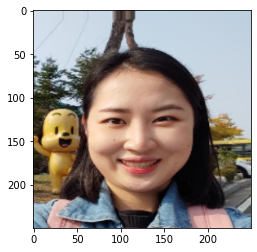

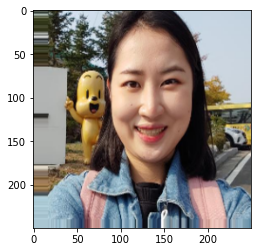

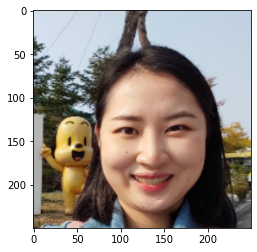

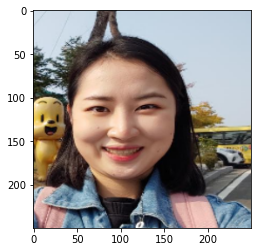

In [8]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

train_Kimchi_dir = train_dir = os.path.join('split/train', 'happy_cropped_image')
fnames = sorted([os.path.join(train_Kimchi_dir, fname) for fname in os.listdir(train_Kimchi_dir)])

# 테스트 이미지 선택
img_path = fnames[0]

# 이미지 읽고 크기 변경
img = image.load_img(img_path, target_size=(250, 250))

# (150, 150, 3) 배열 변환
x = image.img_to_array(img)

# (1, 150, 150, 3) 변환
x = x.reshape((1,) + x.shape)

# 랜덤하게 변환된 이미지 배치 생성
i = 0

for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

### 4) Test train_generator

In [9]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (64, 250, 250, 3)
배치 레이블 크기: (64, 4)


## III. Import VGG-16 Model & Some Layers Freezing

### 1) conv_base

In [10]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-qphwczyl
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-qphwczyl
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [11]:
from classification_models.keras import Classifiers

# for tensorflow keras
from classification_models.tfkeras import Classifiers

Classifiers.models_names()

['resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'seresnet18',
 'seresnet34',
 'seresnet50',
 'seresnet101',
 'seresnet152',
 'seresnext50',
 'seresnext101',
 'senet154',
 'resnet50v2',
 'resnet101v2',
 'resnet152v2',
 'resnext50',
 'resnext101',
 'vgg16',
 'vgg19',
 'densenet121',
 'densenet169',
 'densenet201',
 'inceptionresnetv2',
 'inceptionv3',
 'xception',
 'nasnetlarge',
 'nasnetmobile',
 'mobilenet',
 'mobilenetv2']

In [24]:
SeResNet18, preprocess_input = Classifiers.get('seresnet18')
conv_base = SeResNet18(weights = 'imagenet',
                  include_top = False, # DNN 제외 
                  input_shape = (250, 250, 3)) # input shape을 여기서 바꾼다 

### 2) Model Information

In [25]:
conv_base.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 250, 250, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, 256, 256, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

## IV. CNN Keras Modeling

### 1) Model Define
- Feature Extraction & Classification

In [26]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

model = models.Sequential()
model.add(conv_base)    # freez 없이

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
# model.add(layers.Dense(256, activation = 'relu',
#                        kernel_regularizer = regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
# model.add(layers.Dense(128, activation = 'relu'),
#                        kernel_regularizer = regularizers.l2(0.00001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation = 'softmax'))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 8, 8, 512)         11275969  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               8388864   
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_34 (Activation)  (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

### 2) Model Compile
- 모델 학습방법 설정

In [28]:
from tensorflow.keras import optimizers

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

### 3) Model fit
- 모델 학습 수행

In [29]:
%%time

steps_per_epoch = int(train_generator.n//train_generator.batch_size)
validation_steps = int(valid_generator.n//valid_generator.batch_size)

Hist_dandc = model.fit(train_generator, 
                       steps_per_epoch = steps_per_epoch,
                       epochs = 130, 
                       validation_data = valid_generator,
                       validation_steps = validation_steps )

Epoch 1/130
33/33 [==============================] - 34s 921ms/step - loss: 1.6312 - accuracy: 0.2675 - val_loss: 1.4580 - val_accuracy: 0.2500
Epoch 2/130
33/33 [==============================] - 30s 893ms/step - loss: 1.5700 - accuracy: 0.2822 - val_loss: 1.4577 - val_accuracy: 0.2486
Epoch 3/130
33/33 [==============================] - 30s 900ms/step - loss: 1.4842 - accuracy: 0.3362 - val_loss: 1.4594 - val_accuracy: 0.2500
Epoch 4/130
33/33 [==============================] - 30s 897ms/step - loss: 1.4718 - accuracy: 0.3295 - val_loss: 1.4291 - val_accuracy: 0.2571
Epoch 5/130
33/33 [==============================] - 30s 900ms/step - loss: 1.3912 - accuracy: 0.3764 - val_loss: 1.4111 - val_accuracy: 0.2457
Epoch 6/130
33/33 [==============================] - 30s 898ms/step - loss: 1.3514 - accuracy: 0.3802 - val_loss: 1.4026 - val_accuracy: 0.2514
Epoch 7/130
33/33 [==============================] - 30s 898ms/step - loss: 1.3053 - accuracy: 0.4162 - val_loss: 1.4030 - val_accuracy:

### 4) 학습 결과 시각화
- Loss Visualization

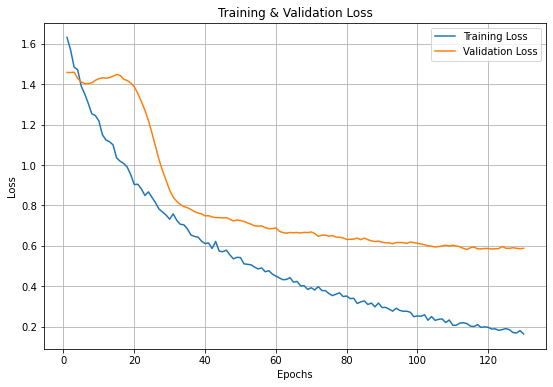

In [30]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

- Accuracy Visualization

Text(0.5, 0, 'Epochs')

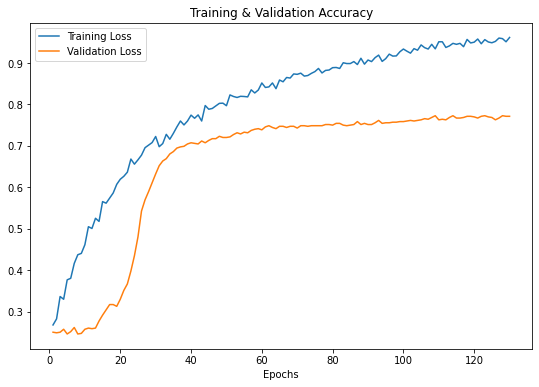

In [31]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')


### 5) Model Evaluate

- test_generator

In [32]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir, 
                 shuffle = False,
                 target_size = (250, 250),
                 batch_size = 32,
                 class_mode = 'categorical')

Found 704 images belonging to 4 classes.


- Loss & Accuracy

In [33]:
loss, accuracy = model.evaluate(test_generator,
                                steps = validation_steps)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

11/11 [==============================] - 1s 66ms/step - loss: 0.5408 - accuracy: 0.8153
Loss = 0.54077
Accuracy = 0.81534


### 6) Confusion Matrix

In [34]:
import numpy as np

# compute predictions
predictions = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

In [35]:
from sklearn.metrics import accuracy_score

print('%.8f' % accuracy_score(y_test, y_pred))

0.79119318


In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[119,  12,  27,  18],
       [  3, 168,   4,   1],
       [ 11,   2, 150,  13],
       [ 21,  11,  24, 120]])

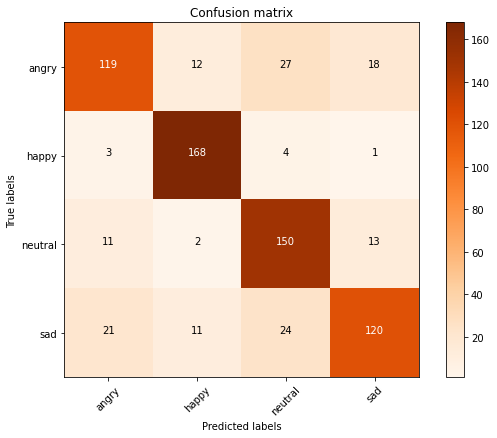

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()

cm = confusion_matrix(y_test, y_pred)
target_names = ['angry', 'happy', 'neutral', 'sad']
plot_confusion_matrix(cm, target_names)

### 7) Classification Report

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, 
                            target_names = ['angry', 'happy', 'neutral', 'sad'],
                            digits = 5))

              precision    recall  f1-score   support

       angry    0.77273   0.67614   0.72121       176
       happy    0.87047   0.95455   0.91057       176
     neutral    0.73171   0.85227   0.78740       176
         sad    0.78947   0.68182   0.73171       176

    accuracy                        0.79119       704
   macro avg    0.79109   0.79119   0.78772       704
weighted avg    0.79109   0.79119   0.78772       704



In [39]:
model.save("SeResNet18_Norm.h5")